# Подготовка окружения

In [9]:
%pip install langdetect pandas numpy seaborn scikit-learn matplotlib nltk transformers torch torchvision wordcloud opentsne

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from datetime import datetime
import nltk
from langdetect import detect as lang_detect, LangDetectException
from transformers import pipeline

import string
import re

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

plt.style.use("seaborn-v0_8")
%matplotlib inline

In [11]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /Users/sasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sasha/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/sasha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sasha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [12]:
np.set_printoptions(threshold=np.inf)

## Импорт датасетов

In [13]:
albums_df = pd.read_csv('./data/spotify_albums.csv', index_col=0)
artists_df = pd.read_csv('./data/spotify_artists.csv', index_col=0)
spotify_tracks_df = pd.read_csv('./data/spotify_tracks.csv', index_col=0)

In [14]:
lyrics_features_df = pd.read_csv('./data/lyrics_features.csv', index_col=0)
low_level_audio_df = pd.read_csv('./data/low_level_audio_features.csv', index_col=0)

In [15]:
data_df = pd.read_csv('./data/data.csv')
songs_df = pd.read_csv('./data/songs_with_attributes_and_lyrics.csv')

In [16]:
genres_df = pd.read_csv('./data/genres.csv')

In [17]:
songs_df = songs_df[['id', 'lyrics']]

In [18]:
tracks_df = data_df.merge(songs_df, on='id', how='left')

### Краткая сводка по датасетам

In [19]:
albums_df.head()

,album_type,artist_id,available_markets,external_urls,href,id,images,name,release_date,release_date_precision,total_tracks,track_id,track_name_prev,uri,type
0,single,3DiDSECUqqY1AuBP8qtaIa,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/1g...,https://api.spotify.com/v1/albums/1gAM7M4rBwEb...,1gAM7M4rBwEbSPeAQR2nx1,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",If I Ain't Got You EP,2019-02-08,day,6,2iejTMy9XZ8Gaae0aQ2yl0,track_32,spotify:album:1gAM7M4rBwEbSPeAQR2nx1,album
1,album,6s1pCNXcbdtQJlsnM1hRIA,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/4K...,https://api.spotify.com/v1/albums/4KfJZV7WfolY...,4KfJZV7WfolYlxBzOTo66s,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Shostakovich Symphony No.5 - Four Romances on ...,2019-03-01,day,8,1WQfghEjszJJ4H8MAWrQ2C,track_11,spotify:album:4KfJZV7WfolYlxBzOTo66s,album
2,single,5YjfNaHq05WrwldRe1QSBc,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/7n...,https://api.spotify.com/v1/albums/7nLYY7uAVUb5...,7nLYY7uAVUb57kpd7tZxnS,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Take My Bass,2019-03-14,day,1,3jJKj4QTK3v18ZSwpk7AcV,track_15,spotify:album:7nLYY7uAVUb57kpd7tZxnS,album
3,single,2G9Vc16JCpnZmK4uGH46Fa,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/6p...,https://api.spotify.com/v1/albums/6p20Rt4x2Qn5...,6p20Rt4x2Qn5mUMRi1s6pj,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Hypnotizing (Are U),2016-11-16,day,1,1xGtDafUZbHyYC3Xarcbrj,track_46,spotify:album:6p20Rt4x2Qn5mUMRi1s6pj,album
4,single,2dwM9OcE4c3Ph1UBINSodx,"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",{'spotify': 'https://open.spotify.com/album/1X...,https://api.spotify.com/v1/albums/1XeoOqC1q7U2...,1XeoOqC1q7U2iyLEQJ64cu,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Sunshine,2018-07-20,day,1,0gWtsXvXOzAT6FtM3ur8in,track_10,spotify:album:1XeoOqC1q7U2iyLEQJ64cu,album


In [20]:
artists_df.head()

,artist_popularity,followers,genres,id,name,track_id,track_name_prev,type
0,44,23230,"['sertanejo', 'sertanejo pop', 'sertanejo trad...",4mGnpjhqgx4RUdsIJiURdo,Juliano Cezar,0wmDmAILuW9e2aRttkl4aC,track_9,artist
1,22,313,[],1dLnVku4VQUOLswwDFvRc9,The Grenadines,4wqwj0gA8qPZKLl5WVqXml,track_30,artist
2,26,1596,['danish pop rock'],6YVY310fjfUzKi8hiqR7iK,Gangway,1bFqWDbvHmZe2f4Nf9qaD8,track_38,artist
3,31,149,['uk alternative pop'],2VElyouiCfoYPDJluzwJwK,FADES,3MFSUBAidPzRBbIS7BDj1S,track_34,artist
4,21,11,['french baroque'],4agVy03qW8juSysCTUOuDI,Jean-Pierre Guignon,2r3q57FhxdsCyYr0kuDq4b,track_26,artist


In [21]:
spotify_tracks_df.head()

,acousticness,album_id,analysis_url,artists_id,available_markets,country,danceability,disc_number,duration_ms,energy,...,preview_url,speechiness,tempo,time_signature,track_href,track_name_prev,track_number,uri,valence,type
0,0.294,0D3QufeCudpQANOR7luqdr,https://api.spotify.com/v1/audio-analysis/5qlj...,['3mxJuHRn2ZWD5OofvJtDZY'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.698,1.0,235584.0,0.606,...,https://p.scdn.co/mp3-preview/1b05a902da3a251d...,0.0262,115.018,4.0,https://api.spotify.com/v1/tracks/5qljLQuKnNJf...,track_14,1.0,spotify:track:5qljLQuKnNJf4F4vfxQB0V,0.6220,track
1,0.863,1bcqsH5UyTBzmh9YizdsBE,https://api.spotify.com/v1/audio-analysis/3VAX...,['4xWMewm6CYMstu0sPgd9jJ'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,656960.0,0.308,...,https://p.scdn.co/mp3-preview/d8140736a6131cb5...,0.9220,115.075,3.0,https://api.spotify.com/v1/tracks/3VAX2MJdmdqA...,track_3,3.0,spotify:track:3VAX2MJdmdqARLSU5hPMpm,0.5890,track
2,0.750,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1L3Y...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.466,1.0,492840.0,0.931,...,https://p.scdn.co/mp3-preview/c8af28fb15185b18...,0.9440,79.565,4.0,https://api.spotify.com/v1/tracks/1L3YAhsEMrGV...,track_4,4.0,spotify:track:1L3YAhsEMrGVvCgDXj2TYn,0.0850,track
3,0.763,6FeJF5r8roonnKraJxr4oB,https://api.spotify.com/v1/audio-analysis/6aCe...,['2KQsUB9DRBcJk17JWX1eXD'],"['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH...",BE,0.719,1.0,316578.0,0.126,...,https://p.scdn.co/mp3-preview/7629b8e9f31f6e9b...,0.9380,112.822,3.0,https://api.spotify.com/v1/tracks/6aCe9zzoZmCo...,track_9,1.0,spotify:track:6aCe9zzoZmCojX7bbgKKtf,0.5330,track
4,0.770,4tKijjmxGClg4JOLAyo2qE,https://api.spotify.com/v1/audio-analysis/1Vo8...,['3hYaK5FF3YAglCj5HZgBnP'],['GB'],BE,0.460,1.0,558880.0,0.942,...,https://p.scdn.co/mp3-preview/32be593c0eb82868...,0.9430,81.260,4.0,https://api.spotify.com/v1/tracks/1Vo802A38tPF...,track_2,2.0,spotify:track:1Vo802A38tPFHmje1h91um,0.0906,track


In [22]:
lyrics_features_df.head()

,mean_syllables_word,mean_words_sentence,n_sentences,n_words,sentence_similarity,track_id,vocabulary_wealth
0,-1.00,-1.00,-1,-1,-1.000000,5KIfHjHI5NIsPHNt58qua0,-1.00
1,1.10,5.65,31,326,0.043011,13keyz9ikBe6ZpRasw7l4X,0.45
2,1.37,4.77,74,532,0.050352,1WugzepXsLjnsM0K4UaWYc,0.59
3,1.95,3.38,72,430,0.028560,2MO6oEAlMKcsfI8xP3yoy8,0.49
4,1.16,2.99,68,368,0.047849,1i4St7fmSUE9nB3R9n8fol,0.47


In [23]:
low_level_audio_df.head()

,Chroma_1,Chroma_10,Chroma_11,Chroma_12,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,...,Tonnetz_4,Tonnetz_5,Tonnetz_6,ZCR,entropy_energy,spectral_bandwith,spectral_centroid,spectral_rollOff_max,spectral_rollOff_min,track_id
0,0.438296,0.472769,0.427441,0.436688,0.467697,0.493862,0.512244,0.568658,0.560524,0.513068,...,0.018434,-0.001759,-0.006392,0.067966,-89.113389,2564.247669,3558.400706,4508.506071,367.831109,19YEk4OVQZn3GfoxbpNrU6
1,0.596605,0.368288,0.285263,0.302211,0.905805,0.510909,0.221708,0.311248,0.491277,0.416469,...,0.046941,0.005665,-0.026928,0.047308,-127.945239,2370.181495,1499.689590,3647.394611,230.165275,6zJms3MX11Qu1IKF44LoRW
2,0.505224,0.500420,0.506773,0.488258,0.498356,0.573582,0.690761,0.742858,0.686282,0.657118,...,-0.006929,0.004968,0.008947,0.058463,-238.285176,2973.294736,1543.550034,5623.349330,187.290534,1WugzepXsLjnsM0K4UaWYc
3,0.525690,0.666469,0.579492,0.498920,0.598528,0.631578,0.501693,0.500468,0.587101,0.546499,...,-0.027382,-0.009689,0.001402,0.080547,-148.785733,2716.749483,3017.248824,5799.931595,160.940693,1pSlTbCrUJ9rmwj5CNNrX4
4,0.632214,0.503698,0.496942,0.611532,0.634613,0.697265,0.557012,0.530836,0.444279,0.466659,...,0.003728,-0.002780,-0.010120,0.084945,-176.618314,3096.692876,2118.686992,6560.018666,229.131948,5yruvWJs3mL00w4slpCVzN


In [24]:
low_level_audio_df.columns.values

array(['Chroma_1', 'Chroma_10', 'Chroma_11', 'Chroma_12', 'Chroma_2',
       'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7',
       'Chroma_8', 'Chroma_9', 'MEL_1', 'MEL_10', 'MEL_100', 'MEL_101',
       'MEL_102', 'MEL_103', 'MEL_104', 'MEL_105', 'MEL_106', 'MEL_107',
       'MEL_108', 'MEL_109', 'MEL_11', 'MEL_110', 'MEL_111', 'MEL_112',
       'MEL_113', 'MEL_114', 'MEL_115', 'MEL_116', 'MEL_117', 'MEL_118',
       'MEL_119', 'MEL_12', 'MEL_120', 'MEL_121', 'MEL_122', 'MEL_123',
       'MEL_124', 'MEL_125', 'MEL_126', 'MEL_127', 'MEL_128', 'MEL_13',
       'MEL_14', 'MEL_15', 'MEL_16', 'MEL_17', 'MEL_18', 'MEL_19',
       'MEL_2', 'MEL_20', 'MEL_21', 'MEL_22', 'MEL_23', 'MEL_24',
       'MEL_25', 'MEL_26', 'MEL_27', 'MEL_28', 'MEL_29', 'MEL_3',
       'MEL_30', 'MEL_31', 'MEL_32', 'MEL_33', 'MEL_34', 'MEL_35',
       'MEL_36', 'MEL_37', 'MEL_38', 'MEL_39', 'MEL_4', 'MEL_40',
       'MEL_41', 'MEL_42', 'MEL_43', 'MEL_44', 'MEL_45', 'MEL_46',
       'MEL_47', 'MEL_48', 'ME

In [25]:
tracks_df.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,lyrics
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0,With pictures and words\n Is this communicatin...
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0,I waited patiently for the Lord\n He inclined ...
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0,I waited patiently for the Lord\n He inclined ...
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0,"Two, three, four\n ♪\n I waited patiently for ..."
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0,"Two, three, four\n ♪\n I waited patiently for ..."


### Очистка датасетов

Удалим не-англоязычные песни

In [26]:
tracks_df['lyrics'] = tracks_df['lyrics'].apply(lambda x: str(x).replace('\r', ' ').replace('\n', ' ').replace('\t', ' ').strip())
tracks_df['lyrics'].replace('', np.nan, inplace=True)
tracks_df.dropna(subset=['lyrics'], inplace=True)
tracks_df = tracks_df[tracks_df['lyrics'].apply(lambda x: len(x.split(' ')) > 10)]
tracks_df = tracks_df[tracks_df['year'] > 1959]

In [27]:
# spotify_tracks_df.drop(spotify_tracks_df[spotify_tracks_df['lyrics'] == '-99'].index, inplace=True)
#
# spotify_tracks_df['lyrics'] = spotify_tracks_df['lyrics'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ').strip())
# df['lyrics'] = df['lyrics'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ').strip())
#
# spotify_tracks_df['lyrics'].replace('', np.nan, inplace=True)
# df['lyrics'].replace('', np.nan, inplace=True)
#
# spotify_tracks_df.dropna(subset=['lyrics'], inplace=True)
# df.dropna(subset=['lyrics'], inplace=True)
#
# spotify_tracks_df = spotify_tracks_df[spotify_tracks_df['lyrics'].apply(lambda x: len(x.split(' ')) > 10)]
# df = df[df['lyrics'].apply(lambda x: len(x.split(' ')) > 10)]

In [28]:
%%time

def detect_language(lyrics):
    try:
        return lang_detect(lyrics)
    except:
        return np.nan

tracks_df['lang'] = tracks_df['lyrics'].apply(detect_language)
tracks_df.dropna(inplace=True)

CPU times: user 6min 30s, sys: 3.19 s, total: 6min 33s
Wall time: 6min 38s


In [29]:
all_tracks_df = tracks_df
tracks_df = tracks_df[tracks_df['lang'] == 'en']

In [30]:
def parse_decade(x):
    if x < 1970:
        return '1960s'
    elif x < 1980:
        return '1970s'
    elif x < 1990:
        return '1980s'
    elif x < 2000:
        return '1990s'
    elif x < 2010:
        return '2000s'
    elif x < 2020:
        return '2010s'
    else:
        return '2020s'

tracks_df['decade'] = tracks_df['year'].apply(parse_decade)
print(tracks_df['decade'].value_counts())

decade
2010s    16368
2000s    14447
1970s    14364
1980s    13736
1990s    13267
1960s    10951
2020s     1350
Name: count, dtype: int64


In [31]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer

lemmatizer = WordNetLemmatizer()
tokenizer = WordPunctTokenizer()

en_stop_words = stopwords.words('english')

In [32]:
words = set(nltk.corpus.words.words())

def clean_lyrics(lyrics):
    lyrics = lyrics.lower()
    lyrics = tokenizer.tokenize(lyrics)
    lyrics = [word for word in lyrics if word not in en_stop_words and word in words]
    lyrics = ' '.join(lyrics)
    lyrics = lyrics.translate(str.maketrans('', '', string.punctuation))
    lyrics = re.sub(r'[^ \w+]', '', lyrics)
    lyrics = ' '.join([lemmatizer.lemmatize(word, pos='n') for word in lyrics.split()])
    return lyrics

tracks_df['clean_lyrics'] = tracks_df['lyrics'].apply(clean_lyrics)

In [33]:
tracks_df[['lyrics', 'clean_lyrics']]

,lyrics,clean_lyrics
0,With pictures and words Is this communicating...,communicating growling voice fading yes heart ...
1,I waited patiently for the Lord He inclined a...,patiently lord cry brought pit miry clay sing ...
2,I waited patiently for the Lord He inclined a...,patiently lord cry lift pit miry clay sing sin...
3,"Two, three, four ♪ I waited patiently for th...",two three four patiently lord cry brought pit ...
4,"Two, three, four ♪ I waited patiently for th...",two three four patiently lord cry brought pit ...
...,...,...
169894,"빨-빨-빨간 맛, 궁금해 honey 깨물면 점점 녹아든 strawberry 그 맛...",honey strawberry corner candy shop baby ninete...
169896,"Get it lifted ♪ What, what, what, what Fire...",get fire truck fireman floor thanks get yeah y...
169897,"Dance, dance, dance, dance Dance, dance, danc...",dance dance dance dance dance dance dance danc...
169901,Come in ♪ 모든 걸 걸고 널 들이킨 나 이젠 돌이킬 수도 없다 이건 ...,come bad one stop love love fantasy oh oh got ...


# Анализ трендов

In [34]:
duplicated_tracks_df = tracks_df

In [35]:
decade_tracks_df = tracks_df[tracks_df['decade'] != '2020s'].groupby('decade').apply(lambda x: x.head(10000)).reset_index(drop=True)

In [36]:
print(decade_tracks_df['decade'].value_counts())

decade
1960s    10000
1970s    10000
1980s    10000
1990s    10000
2000s    10000
2010s    10000
Name: count, dtype: int64


## Анализ текстов

In [37]:
count_vect = CountVectorizer(stop_words=en_stop_words)

In [38]:
lyrics_cv = count_vect.fit_transform(decade_tracks_df['clean_lyrics'])

tracks_cv = pd.DataFrame(lyrics_cv.toarray(),columns=count_vect.get_feature_names_out())
tracks_cv['decade'] = tracks_df['decade']
tracks_cv = tracks_cv.groupby('decade').sum().T.reset_index(level=0).rename(columns ={'index':'words'}).rename_axis(columns='')
tracks_cv = tracks_cv[['words', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']]

In [39]:
from wordcloud import WordCloud

def plot_wordcloud(ax, df, decade):
    wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
    freq_dict = dict(zip(df['words'].tolist(), df[decade].tolist()))
    ax.imshow(wc.generate_from_frequencies(freq_dict), interpolation='bilinear')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(decade)

Text(0.5, 0.98, 'Самые используемые слова в песнях')

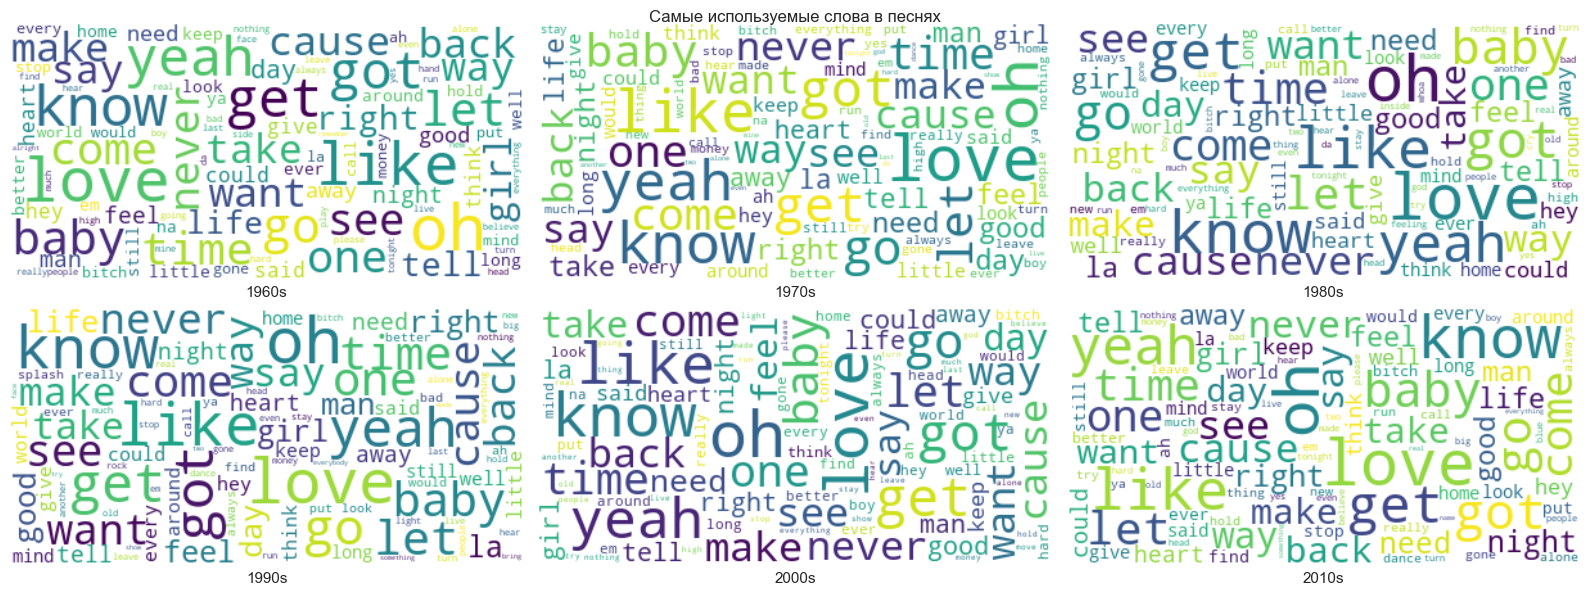

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

for i, ax in zip(range(tracks_cv.columns[1:].size), axes.flat):
    plot_wordcloud(ax, tracks_cv, tracks_cv.columns[1:][i])

plt.tight_layout()
plt.suptitle('Самые используемые слова в песнях')

Попробуем избавиться от всех частей речи, кроме существительных

In [41]:
tags = nltk.pos_tag(tracks_cv['words'])
nouns = [word for word,pos in tags if pos[:2] == 'NN']

nouns_df_cv = tracks_cv[tracks_cv['words'].isin(nouns)]

Text(0.5, 0.98, 'Самые используемые слова в песнях')

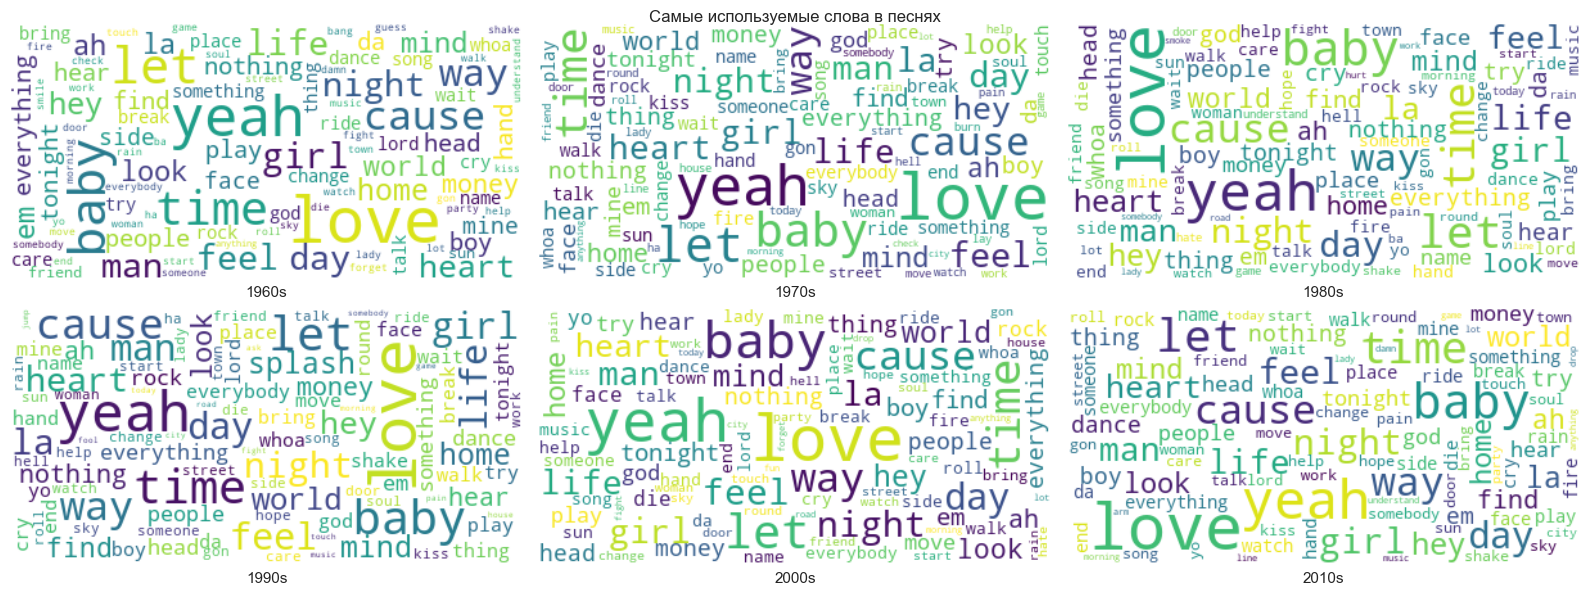

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

for i, ax in zip(range(nouns_df_cv.columns[1:].size), axes.flat):
    plot_wordcloud(ax, nouns_df_cv, nouns_df_cv.columns[1:][i])

plt.tight_layout()
plt.suptitle('Самые используемые слова в песнях')

In [43]:
def print_top_10_words(decade):
    return nouns_df_cv.sort_values(decade, ascending=False)[['words', decade]].head(10)

Теперь построю гистограмму с частотностью использования слов, которые встречаются в топ-10 всех декад.

In [44]:
top_60s = print_top_10_words('1960s')
top_70s = print_top_10_words('1970s')
top_80s = print_top_10_words('1980s')
top_90s = print_top_10_words('1990s')
top_2000s = print_top_10_words('2000s')
top_2010s = print_top_10_words('2010s')

In [45]:
intersection = np.intersect1d(top_60s['words'], top_70s['words'])
intersection = np.intersect1d(intersection, top_80s['words'])
intersection = np.intersect1d(intersection, top_90s['words'])
intersection = np.intersect1d(intersection, top_2000s['words'])
intersection = np.intersect1d(intersection, top_2010s['words'])
intersection

array(['baby', 'cause', 'day', 'let', 'love', 'time', 'way', 'yeah'],
      dtype=object)

In [46]:
top_df_cv = nouns_df_cv[nouns_df_cv['words'].isin(intersection)]
top_df_cv

,words,1960s,1970s,1980s,1990s,2000s,2010s
1342,baby,4925,6716,6357,5868,7486,8771
3275,cause,3379,4649,4411,4475,5050,6217
5337,day,2457,3644,3712,3525,4229,5008
12184,let,4992,6951,5747,5843,6542,7899
12560,love,8571,12707,11691,11026,12086,15820
22035,time,4536,6260,5544,5960,6325,7653
24223,way,3054,4491,4167,4207,5025,5698
24855,yeah,6611,9404,8376,8059,10173,10961


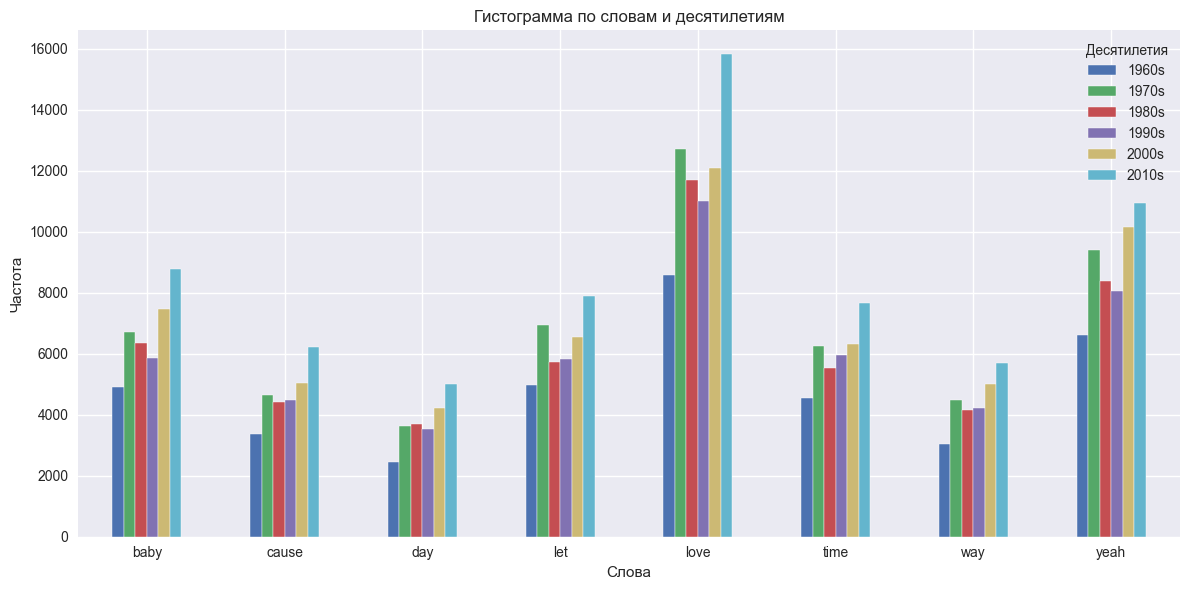

In [47]:
top_df_cv.set_index('words').plot(kind='bar', figsize=(12, 6))
plt.title('Гистограмма по словам и десятилетиям')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.legend(title='Десятилетия')
plt.xticks(rotation=0)
plt.tight_layout()

## Анализ аудиоданных

Для начала проверим, как менялись тренды в песнях по некоторым характеристикам: `danceability`, `loudness`, `acousticness`, `instrumentalness`, а также `loudness`

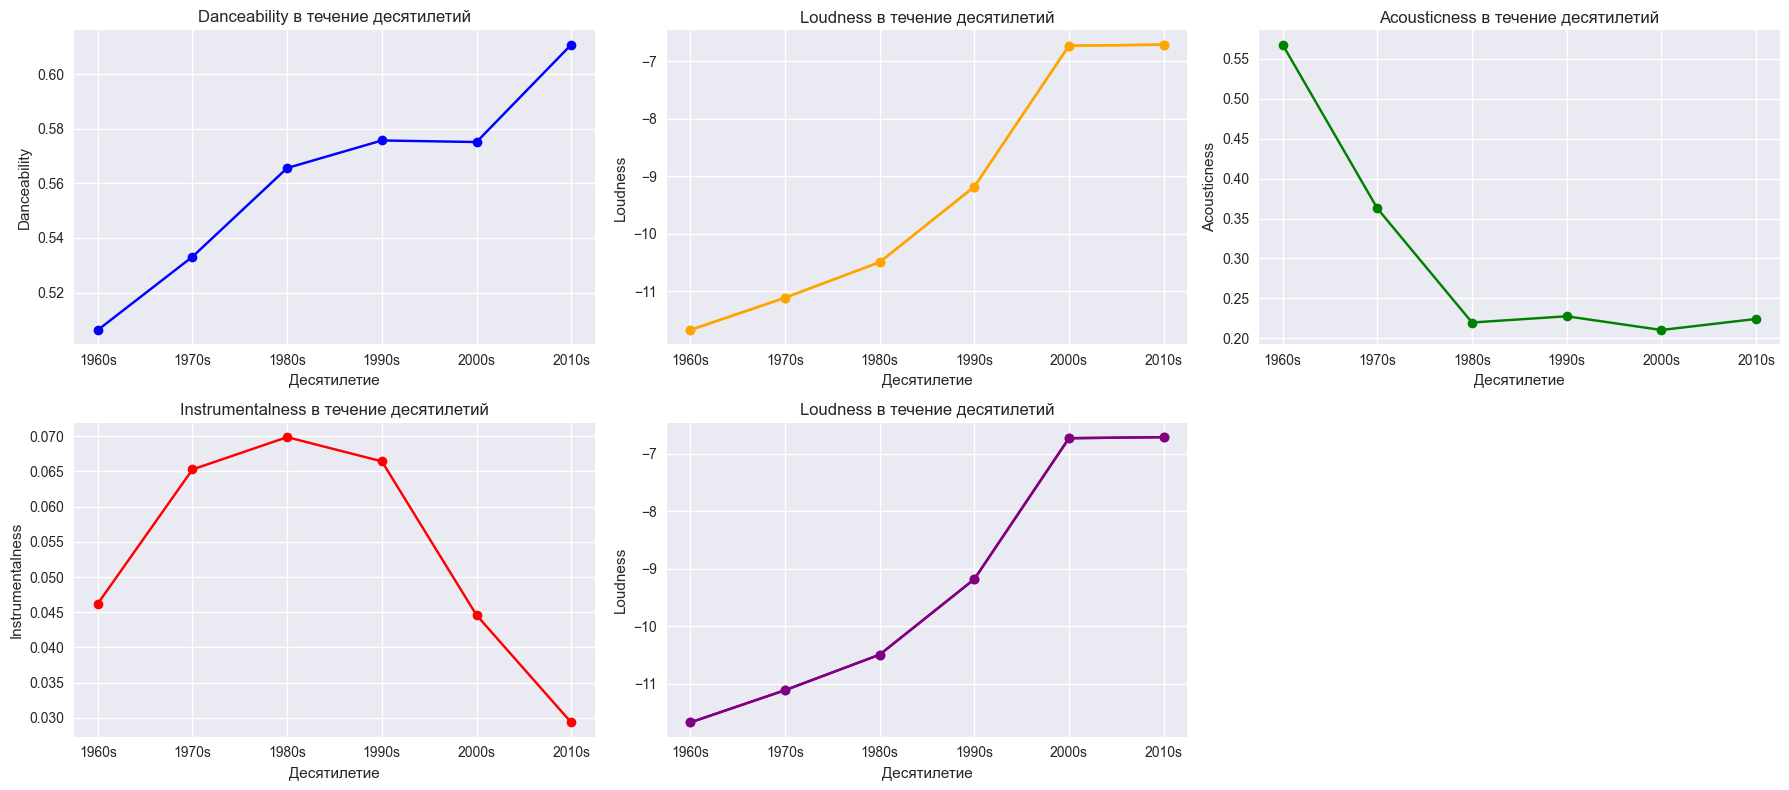

In [48]:
trends = decade_tracks_df.groupby('decade')[['danceability', 'loudness', 'acousticness', 'instrumentalness', 'loudness']].mean().reset_index()

features = ['danceability', 'loudness', 'acousticness', 'instrumentalness', 'loudness']
titles = ['Danceability в течение десятилетий', 'Loudness в течение десятилетий',
          'Acousticness в течение десятилетий', 'Instrumentalness в течение десятилетий',
          'Loudness в течение десятилетий']
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(18, 8))

for i, (feature, title, color) in enumerate(zip(features, titles, colors), start=1):
    plt.subplot(2, 3, i)
    plt.plot(trends['decade'], trends[feature], marker='o', color=color)
    plt.title(title)
    plt.xlabel('Десятилетие')
    plt.ylabel(feature.capitalize())

plt.tight_layout()

In [49]:
genres_df = genres_df.replace('Children’s Music', 'Children\'s Music')

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [57]:
genres_df = genres_df[['track_id', 'genre']]

genres_decade_tracks_df = decade_tracks_df.merge(genres_df, how='left', left_on='id', right_on='track_id').drop('track_id', axis=1)
genres_decade_tracks_df = genres_decade_tracks_df[genres_decade_tracks_df['decade'] != '2020s'].groupby('decade').apply(lambda x: x.head(10000)).reset_index(drop=True)

genres_decade_tracks_df['norm_tempo'] = scaler.fit_transform(genres_decade_tracks_df[['tempo']])
genres_decade_tracks_df = genres_decade_tracks_df.replace('Children’s Music', 'Children\'s Music')

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=8000, stop_words=en_stop_words)

lyrics_tdidf = tfidf.fit_transform(genres_decade_tracks_df['clean_lyrics'])
lyrics_tdidf_df = pd.DataFrame(lyrics_tdidf.toarray())
lyrics_tdidf_df = lyrics_tdidf_df.add_prefix('word_')

In [92]:
genres_decade_tracks_df_text = pd.concat([genres_decade_tracks_df.reset_index(drop=True), lyrics_tdidf_df.reset_index(drop=True)], axis=1)

In [93]:
genres_decade_tracks_df_text.shape

(60000, 8025)

In [94]:
genres_decade_tracks_df_text['genre'].unique()

array(['Rock', 'Blues', 'Folk', 'Pop', 'Soul', 'Jazz', 'Alternative',
       'Reggae', 'Ska', 'Country', 'World', 'Dance', 'Classical', 'Movie',
       'Soundtrack', 'Indie', 'Electronic', "Children's Music", 'Comedy',
       'R&B', 'Hip-Hop', 'Rap', 'Anime', 'Reggaeton', 'Opera'],
      dtype=object)

In [100]:
known_data = genres_decade_tracks_df_text[genres_decade_tracks_df_text['genre'].notna()]
unknown_data = genres_decade_tracks_df_text[genres_decade_tracks_df_text['genre'].isna()]

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'norm_tempo', 'valence', 'mode', 'key', 'explicit'] + [f"word_{i}" for i in range(8000)]
# features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'norm_tempo', 'valence', 'mode', 'key', 'explicit']

all_data = genres_decade_tracks_df_text[features]

initial_centroids = known_data.groupby('genre')[features].mean().values
n_clusters = len(known_data['genre'].unique())

In [101]:
known_data['genre'].unique()

array(['Rock', 'Blues', 'Folk', 'Pop', 'Soul', 'Jazz', 'Alternative',
       'Reggae', 'Ska', 'Country', 'World', 'Dance', 'Classical', 'Movie',
       'Soundtrack', 'Indie', 'Electronic', "Children's Music", 'Comedy',
       'R&B', 'Hip-Hop', 'Rap', 'Anime', 'Reggaeton', 'Opera'],
      dtype=object)

In [102]:
from sklearn.cluster import KMeans

kmeans_genre = KMeans(n_clusters, init=initial_centroids)

In [103]:
clusters = kmeans_genre.fit_predict(all_data)

known_cluster_labels = clusters[:len(known_data)]
unknown_cluster_labels = clusters[len(known_data):]

In [104]:
cluster_to_genre = {}
for cluster in range(n_clusters):
    cluster_genres = known_data[clusters[known_data.index] == cluster]['genre']
    most_common_genre = cluster_genres.value_counts().idxmax()
    cluster_to_genre[cluster] = most_common_genre

In [105]:
unknown_data['genre'] = [cluster_to_genre[label] for label in unknown_cluster_labels]

In [106]:
from openTSNE.sklearn import TSNE

tsne_genre = TSNE(perplexity=200).fit_transform(all_data.to_numpy())

In [107]:
tsne_genre_df = pd.DataFrame(tsne_genre)
tsne_genre_df['cluster'] = clusters

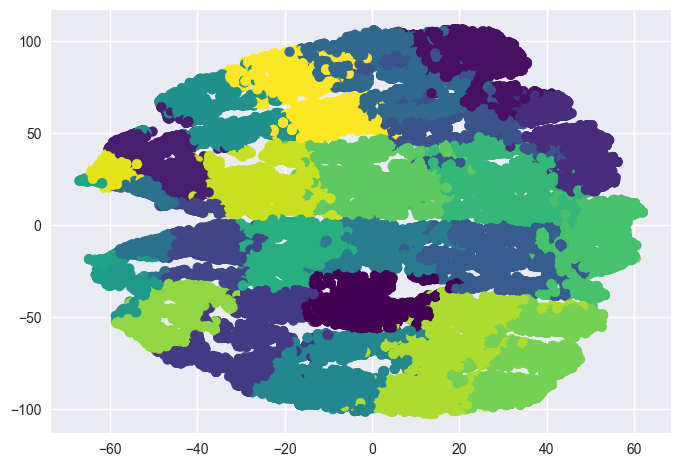

In [108]:
plt.scatter(tsne_genre_df.iloc[:,0] , tsne_genre_df.iloc[:,1], c=clusters, cmap='viridis')

In [109]:
genres_decade_tracks_df_text['genre'] = pd.concat([known_data, unknown_data])['genre']
genres_decade_tracks_df['genre'] = genres_decade_tracks_df_text['genre']

<Axes: >

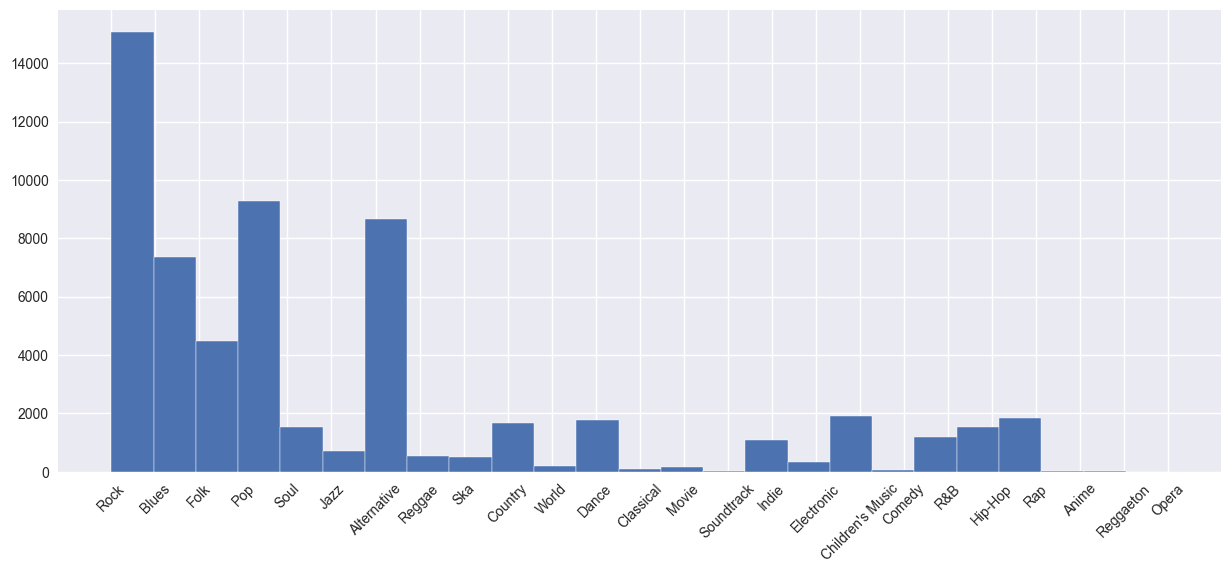

In [135]:
genres_decade_tracks_df['genre'].hist(figsize=(15, 6), xrot=45, bins=25)

In [186]:
top_genres = genres_decade_tracks_df['genre'].value_counts().head(4).reset_index()['genre'].tolist() + ['Rap']
top_genres

['Rock', 'Pop', 'Alternative', 'Blues', 'Rap']

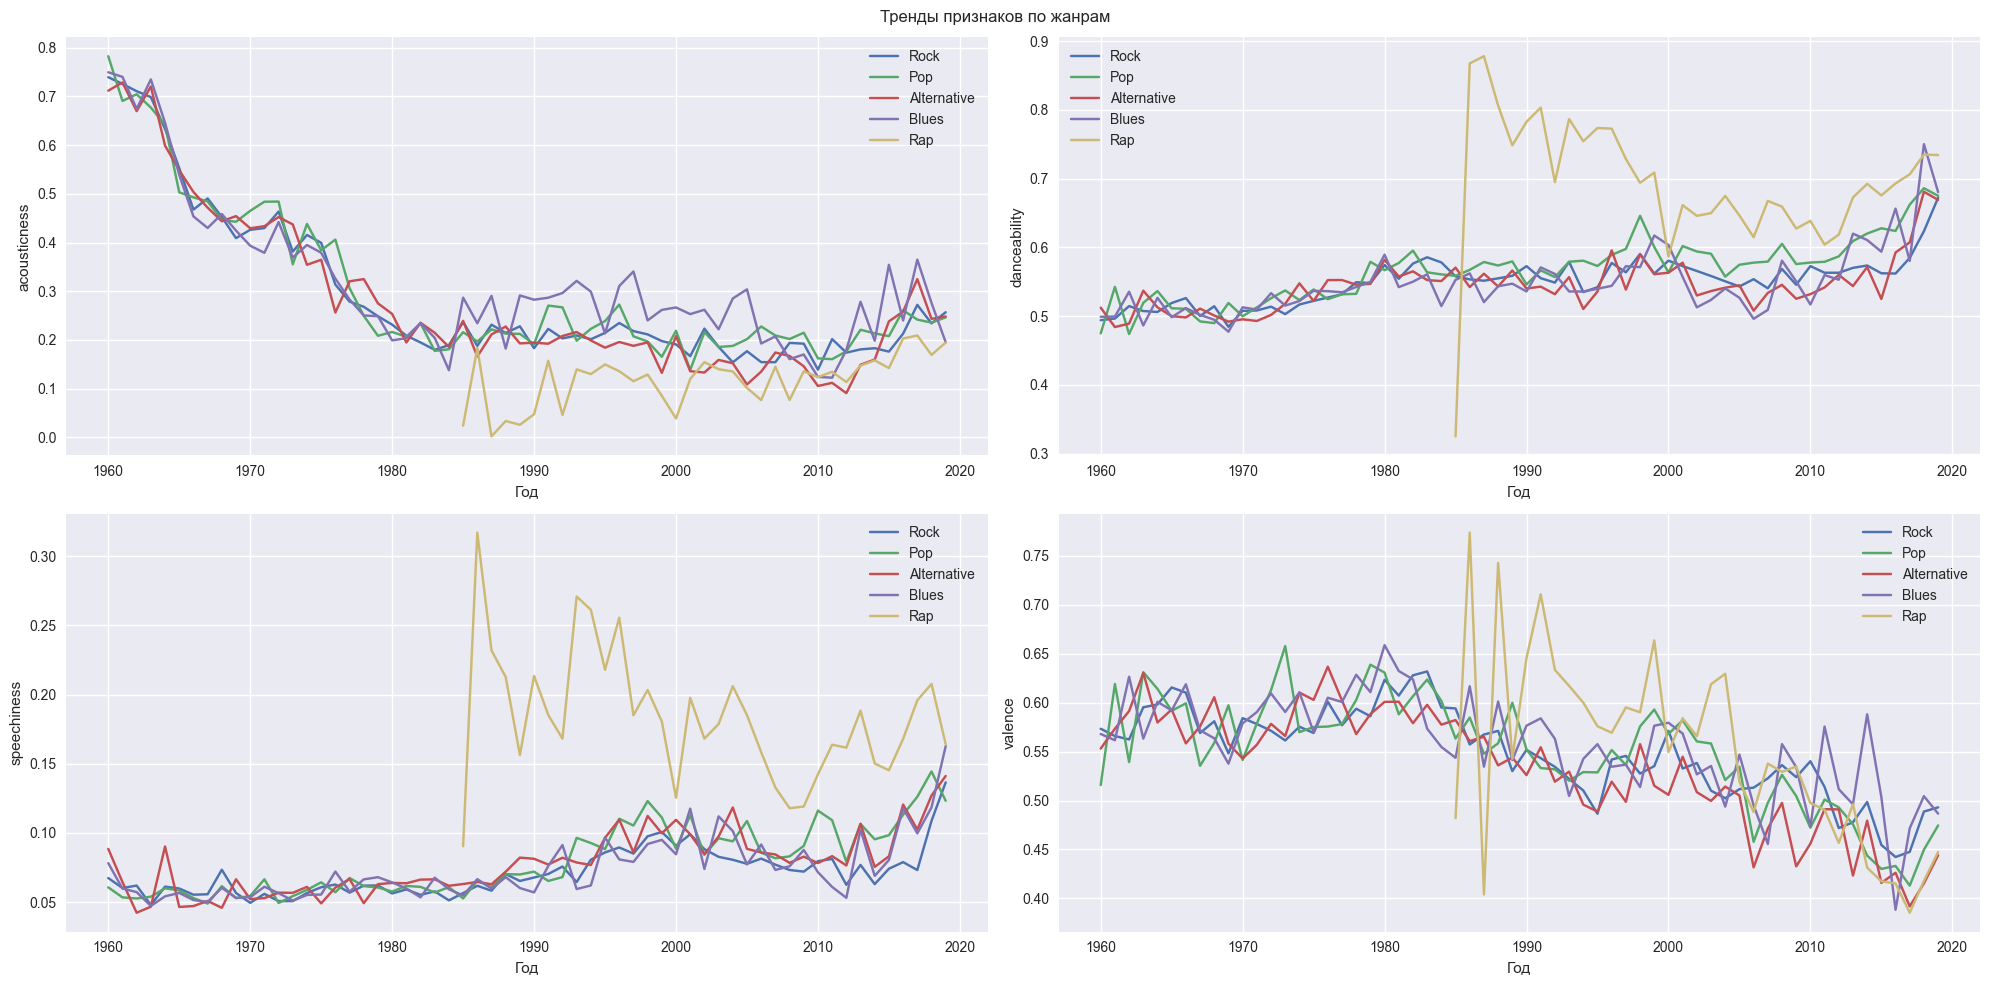

In [188]:
features = ['acousticness', 'danceability', 'speechiness', 'valence']
trends = genres_decade_tracks_df.groupby(['genre', 'year'])[features].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for genre in top_genres:
    for i, ax in zip(range(len(features)), axes.flat):
        ax.plot(trends[trends['genre'] == genre]['year'], trends[trends['genre'] == genre][features[i]])
        ax.set_xlabel('Год')
        ax.set_ylabel(features[i])
        ax.legend(top_genres)

plt.suptitle('Тренды признаков по жанрам')
plt.tight_layout()